# Demo: Classical Iterative Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg
import scipy.linalg
import time
import sys

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In this demo we examine several iterative methods for approximating solutions of 
$$ Ax = b .$$
Speficially, we look at the Jacobi, weighted Jacobi, Gauss-Seidel, and successive over-relaxation methods. We compare the performance of each of these methods to direct Gaussian elimination/LU decomposition, and to the conjugate gradient method. 

The idea behind all of these iterative methods begins (following Wendland's book, ch. 4) by recasting $Ax= b$ as an equivalent fixed point problem. Suppose that $B$ is any easily invertible matrix of the same size as $A$ (you know what I mean by "easily invertible", right?). Trivially, we can split $A$ according to 
$$
A = A- B +B. 
$$
From here, $Ax=b$ implies 
$$
Bx = \left(B-A\right)x - b. 
$$
Multiplying both sides by 
$B^{-1}$ gives
$$ x = \left(I-B^{-1}A\right) x - B^{-1}b.$$
Therefore, the solution of our linear system must be a fixed point of the affine map
$$ F(x) \doteq \left(I-B^{-1}A\right) x - B^{-1}b. $$
The philosophy behind iterative methods is now clear: if we can choose $B$ carefully enough for $F$ to be a **contraction mapping**, then given any initial guess $x^{(0)}$ of $x$, we can form a sequence of improved guesses $\left\{x^{(n)}\right\}_{n}$ recursively using the rule
$$ x^{(n)} = F\left(x^{(n-1)}\right).$$
The iteration can be stopped once successive iterates become sufficiently near one another, or another reasonable convergence criterion is met. Note that this procedure does not produce an *exact* solution to $Ax=b$, but for sufficiently nice $A,B$ it will produce an approximate solution. That is, we want to have the convergence property
$$ \lim_{n\rightarrow \infty} \left\|x^{(n)}-x\right\| = 0 $$
with $\left\|\cdot\right\|$ a suitable norm on our vector space. 

You are no doubt asking how the nice matrix $B$ can be systematically chosen. There are two basic routes: 

1) **Jacobi's method** . Start by splitting $$ A = D-L-U $$ where $D$ is nonzero only on the diagonal, $L$ is lower triangular, and $U$ is upper triangular. We assume all diagonal entries of $A$, and therefore $D$, are nonzero (this is usually reasonable in applications to differential equations). Then, we choose $$ B = D. $$ We all agree that $B$ is trivial to extract from $A$, and indeed to invert exactly! This gives us the update rule 
$$ x^{(n)} = \left(1-D^{-1}\left(D-L-U\right)\right)x^{(n-1)} + D^{-1}b = D^{-1}\left(L+U\right)x^{(n-1)} + D^{-1}b. $$
So, to check if our iteration converges, by the contraction mapping theorem it suffices to control suitable norms of the **iteration matrix** $$R = D^{-1}\left(L+U\right). $$
Under some **diagonal dominance** conditions, the iteration matrix has a sufficiently small spectral radius and therefore the Jacobi method converges, see Wendland for full details. 

Also, notice that the Jacobi iteration can be simplified a bit by introducing the **residual** 
$$ r^{(n)} = b - Ax^{(n)}.$$
This allows us to write $$ x^{(n)} = x^{(n-1)} +D^{-1}\left(b - Ax^{(n-1)}\right) = x^{(n-1)} +D^{-1}r^{(n-1)}. $$
So, the method takes a particularly easy form if we compute the residual at each iteration. No matter what particular form of Jacobi iteration we choose, we notice that implementation is going to be trivial! A small remark: in numerical linear algebra, the residual is a useful general tool, but always keep in mind that a small residual does not necessarily imply small error! 

2) **Gauss-Seidel Method** . You may notice that Jacobi's method is completely explicit: every entry of $x^{(n)}$ depends only on entries of $x^{(n-1)}$. Intuitively, we can do better by using particular entries of $x^{(n)}$ that have already been computed to inform computations of other entries: we compute $x^{(n)}_{1}$ first using all of $x^{(n-1)}$, then use this guess and all of $x^{(n-1)}$ to compute $x^{(n)}_{2}$, and so on. This amounts to choosing $$ B = D- L $$ in the notation set up when discussing Jacobi. A step of this iteration then amounts to solving the triangular system
$$ (D-L)x^{(n)} = Ux^{(n-1)} + b $$
(draw a diagram of the matrix sparsity structure in each case to see why this gives us what we want!). This breed of linear system can of course be handled computationally via back-substitution, so the Gauss-Seidel method is  only slightly more difficult to implement than the Jacobi method. Provided that $A$ satisfies some diagonal dominance conditions, a theorem of Sassenfeld (see again Wendland's book) shows that this small extra difficulty pays off and gives us faster convergence than Jacobi! We verify this result empirically below. The reader should, however, take a moment and try to come up with a general computational situation where Jacobi would definitely be more efficient than Gauss-Seidel. 

One can also sometimes sharpen this convergence of these techniques by letting $x^{(n)}$ be a weighted average of $x^{(n-1)}$ and the current Jacobi/Gauss-Seidel guess. This leads to the **weighted Jacobi method** or the **successive over-relaxation method**. We won't discuss the formulas in detail right now, but it's worth noting both that the codes below allow you to take these weighted averages if you so desire. For the concrete examples presented here, adding a weight doesn't really change the performance much, but later on when we get to finite difference methods for boundary-value problems and multigrid techniques, we'll want to pay more attention to the weights in question. 

First, we implement the weighted Jacobi method. 

In [2]:
def solve_Jacobi(A,b, x0, weight = 1): # default to weight=1 which is vanilla Jacobi
    tol = 1e-5
    
    max_its = 1e2

    d = A.diagonal() #TODO: print error if any entry of d is zero
        
    d_inv = 1./d
            
    D_inv = sparse.diags([d_inv], [0], shape=np.shape(A)).toarray()
        
    R = (1-weight)*np.eye(np.shape(A)[0]) +  weight*np.matmul(D_inv, -1.*(np.triu(A,1) + np.tril(A,-1))) # iteration matrix .
    # Note: the functions triu and tril extract entries above or below a set diagonal (inclusive),
    # resp. 
    
    r = b - np.matmul(A,x0) # residual at current step
    
    r = np.ravel(r) # extra safety factor for sizing... if you're dealing with 
    # A built partially or in the whole by the sparse matrix package, some subtle
    # array size issues come up, and ravel fixes them nicely. 
    
    res_data = np.array([]) # array storing residual errors for pedagogical purposes
    
    res_data = np.append(res_data, np.linalg.norm(r))
    
    speed_flag = 1. # difference between past two iterates, the smallness of which is used 
    # as a stopping criterion. Start it large to get iteration going
    
    speed_data = np.array([]) # array storing differences between successive guesses.
    # again for pedagogical purposes

    cnt = 0 # iteration counter 
    
    while speed_flag >= tol and cnt < max_its: 
        # stop iteration if consecutive guesses are close or we
        # exceed maximum number of iterations
        
        if cnt >0 : 
            
            x0 = x 
        
        x = x0 + weight*np.matmul(D_inv, r)
        
        r = b - np.matmul(A,x)
        
        r = np.ravel(r)
        
        res_data = np.append(res_data, np.linalg.norm(r))
        
        speed_flag = np.linalg.norm(x-x0)
        
        speed_data = np.append(speed_data, speed_flag)
        
        cnt += 1
        
    return x, cnt, R, res_data, speed_data # want to return R only for the purposes 
    #of error/convergence analysis (checking its spectral radius)

We can first test our implementation on a simple system: $$ \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}x = \begin{bmatrix} 1 \\ 1\end{bmatrix},$$
the exact answer of which is readily verified to be 
$$ x = \begin{bmatrix} 0 \\ 1 \end{bmatrix}.$$ The iteration is initialized with a random (standard normal) choice of $x^{(0)}$. 

In [3]:
A = np.array([[1,1],[0,1]])
x_true = np.array([0,1])
b = np.matmul(A,x_true)

x_approx, cnt, R, res_data, speed_data = solve_Jacobi(A,b,np.random.rand(2), 1)

print('Spectral radius of iteration matrix=', np.amax(np.abs(np.linalg.eigh(R)[0]))) # print spectral radius
print('L^2 Error = ', np.linalg.norm(x_approx-x_true))
print('Number of iterations = ', cnt)

Spectral radius of iteration matrix= 0.0
L^2 Error =  1.1102230246251565e-16
Number of iterations =  3


So, in 3 iterations Jacobi gives us the exact answer, and everything is hunky-dory so far!

Let's try a tougher example: take $A$ to be a random (standard normal) sparse symmetric perturbation of the $N\times N$ identity matrix, and let $b$ be a random (standard normal) vector of length $N$, where $N\gg 1$. 

In [4]:
N = np.int(1e3) # Strictly speaking 1000 is a bit too small to see improvements over 
# Gaussian elimination, but for a bigger matrix we'd need to use the sparse matrix library in a 
# more sophisticated way... TODO follow up on this!

B = sparse.random(N, N, density=0.4, data_rvs=np.random.randn) # create a sparse matrix object
B = B.toarray() # change sparse matrix object to a numpy array
# sparsity ratio/density is given as 40% here, can increase or decrease as you please

#B = np.random.randn(N,N) # in case you want a dense random perturbation instead

A = np.eye(N) + 2e-2*0.5*(B+B.T)
x_true = np.random.randn(N)
b = np.matmul(A, x_true)

Now, we run this problem through our Jacobi solver. 

In [21]:
start=time.time()
x_approx, cnt, R, res_data, speed_data = solve_Jacobi(A,b, np.random.randn(N), 1)
end=time.time()

print('Spectral radius of iteration matrix=', np.amax(np.linalg.eigh(R)[0])) # print spectral radius
# note that the iteration matrix is symmetric so no need to take absolute values in output of eigh
print('L^2 Error for Weighted Jacobi = ', np.linalg.norm(x_approx-x_true))
print('Number of iterations = ', cnt)
print('Runtime =', end-start, 's')

Spectral radius of iteration matrix= 0.5702882390849939
L^2 Error for Weighted Jacobi =  2.506064944548052e-06
Number of iterations =  25
Runtime = 0.08786129951477051 s


We can visualize the speed of convergence nicely using a log plot of the residual error and the difference between successive iterates. We also plot the lines of best fit for both quantities. 

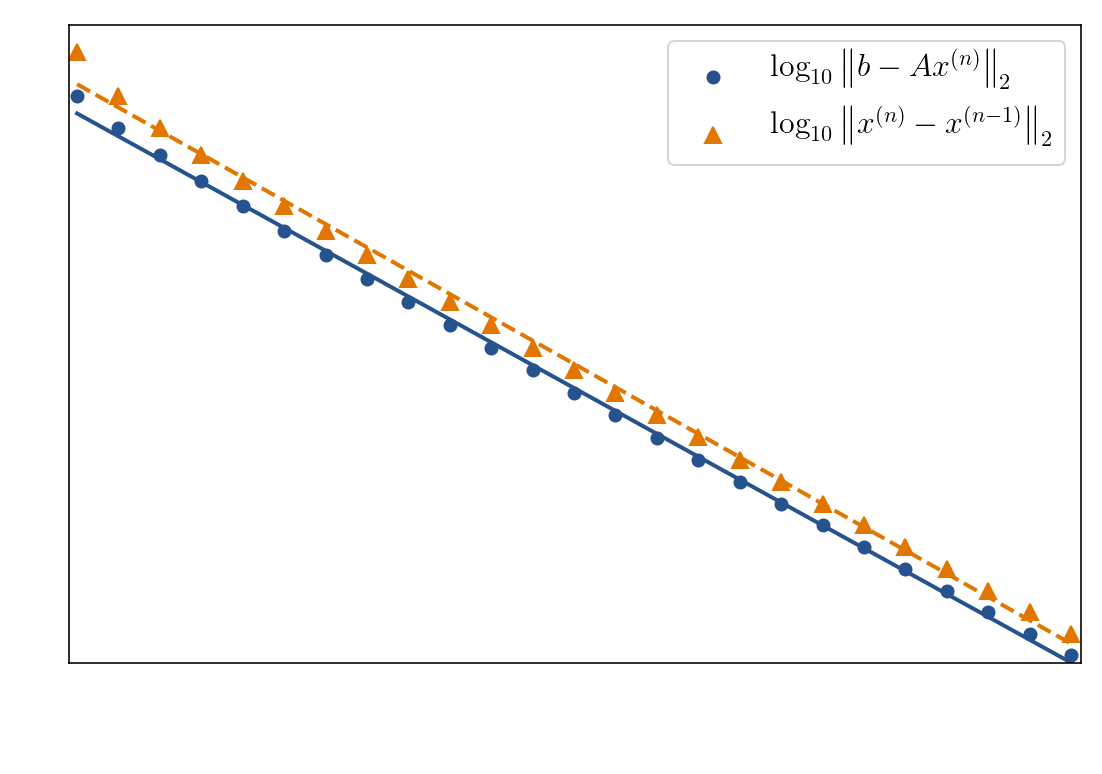

In [22]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
    
ndata= np.arange(0,cnt+1)[1:]
    
plt.plot(ndata, np.log10(res_data[1:]), 'o', color='xkcd:dusk blue', linewidth='2', label=r"$\log_{10}\left\|b-Ax^{(n)}\right\|_{2}$")
params = np.polyfit(ndata, np.log10(res_data[1:]), 1)
slope = params[0]
intercept = params[1]
plt.plot(ndata, slope*ndata+intercept, color='xkcd:dusk blue', linewidth='2')

plt.plot(ndata, np.log10(speed_data), '^', color='xkcd:pumpkin',  markersize=8 ,label=r"$\log_{10}\left\|x^{(n)}-x^{(n-1)}\right\|_{2}$")
params = np.polyfit(ndata, np.log10(speed_data), 1)
slope = params[0]
intercept = params[1]
plt.plot(ndata, slope*ndata+intercept, color='xkcd:pumpkin', linewidth='2', linestyle='--')

plt.xlim([0.8,cnt+0.25])
plt.ylim([-5.6,2])

ax.legend(fontsize=16)

plt.xlabel(r"Iteration Number $n$", fontsize=26, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600
    
plt.show()

From this figure, we see that the residual decreases exponentially quickly, as does the distance between successive iterates. 

Now, we test the performance of Jacobi against Gaussian elimination/LU decomposition. 

In [7]:
start = time.time()
L, U = scipy.linalg.lu(A)[1:]
y = scipy.linalg.solve_triangular(L, b, lower=True) # lower=True means only use lower triangle
x_approx = scipy.linalg.solve_triangular(U, y, lower=False)
end=time.time()

print('L^2 Error for Gaussian Elimination = ', np.linalg.norm(x_approx-x_true))
print('Runtime =', end-start, 's')

L^2 Error for Gaussian Elimination =  5.296184895538863e-14
Runtime = 0.031151533126831055 s


In this example, Gaussian elimination delivers much better error in around the same time frame. So, iterative techniques do not always deliver an improvement over exact ones. 

Finally, we can test this problem against the gold standard for sparse SPD matrix solvers, the conjugate gradient algorithm (CG) of Hestenes and Stiefel. Technically we're winging the "positivity" requirement a bit since we have no guarantee that $A$ is strictly positive definite, but from the way $A$ is constructed I think it's intuitively clear $A$ never has nontrivial kernel. 

In [8]:
start = time.time()
x_approx = scipy.sparse.linalg.cg(A,b, x0=np.random.randn(N))[0] # put [0] to avoid convergence flag
end=time.time()

print('L^2 Error for Conjugate Gradient Iteration = ', np.linalg.norm(x_approx-x_true))
print('Runtime =', end-start, 's')

L^2 Error for Conjugate Gradient Iteration =  0.00037611666088197416
Runtime = 0.00966787338256836 s


CG performs much faster than either Jacobi or Gaussian elimination, and the error is pretty good (typically on the order of $10^{-4}$ in my experiments). So, I would say that for this type of problem CG and Jacobi are nearly tied, and you can choose a winner only after stating whether you value accuracy more than speed or vice versa. 

Next, we implement GS. 

In [9]:
def solve_GS(A,b, x0):
    tol = 1e-5
    
    max_its = 1e2
    
    # Split matrix A
    
    U = -1.*np.triu(A,1)
    
    DminL = np.tril(A) # D- L, matrix to be inverted
    
    Inverse = scipy.linalg.inv(DminL)
    
    R = np.matmul(Inverse, U) # iteration matrix
        
    r = b - np.matmul(A,x0) # residual at current step
    
    r = np.ravel(r) # extra safety factor for sizing
    
    res_data = np.array([]) # array storing residual errors for pedagogical purposes
    
    res_data = np.append(res_data, np.linalg.norm(r))
    
    speed_flag = 1. # difference between past two iterates, the smallness of which is used 
    # as a stopping criterion. Start it large to get iteration going
    
    speed_data = np.array([]) # array storing differences between successive guesses.
    # again for pedagogical purposes
    
    cnt = 0 # iteration counter 
    
    while speed_flag >= tol and cnt < max_its: 
        # stop iteration if consecutive guesses are close or we
        # exceed maximum number of iterations
        
        if cnt >0 : 
            
            x0 = x 
        
        y = np.matmul(U, x0)
        
        x = scipy.linalg.solve_triangular(DminL,y+b, lower=True)
        
        r = b-np.matmul(A,x)
                
        r = np.ravel(r)
        
        res_data = np.append(res_data, np.linalg.norm(r))
        
        speed_flag = np.linalg.norm(x-x0)
        
        speed_data = np.append(speed_data, speed_flag)
        
        cnt += 1
        
    return x, cnt , R, res_data, speed_data

In [10]:
start=time.time()
x_approx, cnt, R, res_data, speed_data = solve_GS(A,b, np.random.randn(N))
end=time.time()

print('Spectral radius of iteration matrix=', np.amax(np.linalg.eigh(R)[0]))
print('L^2 Error for Gauss-Seidel= ', np.linalg.norm(x_approx-x_true))
print('Number of iterations = ', cnt)
print('Runtime =', end-start, 's')

Spectral radius of iteration matrix= 0.2311644648335253
L^2 Error for Gauss-Seidel=  2.752013275033621e-06
Number of iterations =  13
Runtime = 0.1336970329284668 s


The timing of Gauss-Seidel is not strictly speaking fair here, since we need to invert a matrix to check the spectral radius and this is very costly. 

We can also visualize the Gauss-Seidel convergence nicely: 

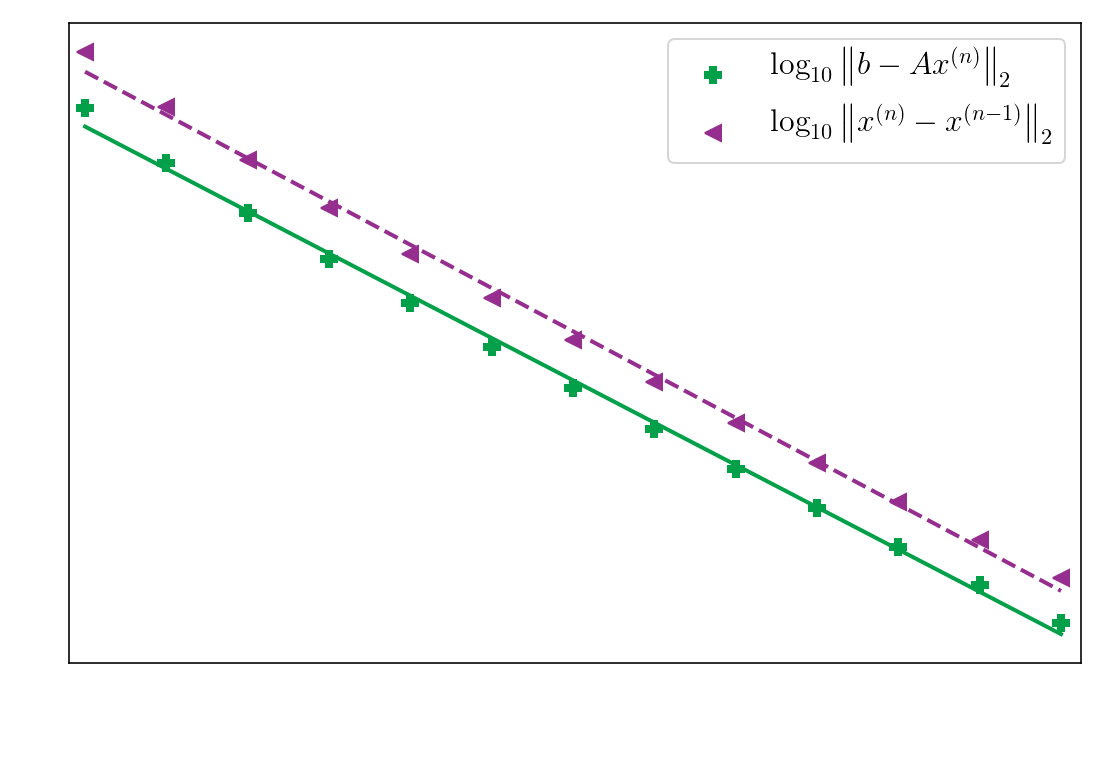

In [11]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
    
ndata= np.arange(0,cnt+1)[1:]
    
plt.plot(ndata, np.log10(res_data[1:]), 'P', color='xkcd:emerald', markersize=8, label=r"$\log_{10}\left\|b-Ax^{(n)}\right\|_{2}$")
params = np.polyfit(ndata, np.log10(res_data[1:]), 1)
slope = params[0]
intercept = params[1]
plt.plot(ndata, slope*ndata+intercept, color='xkcd:emerald', linewidth='2')

plt.plot(ndata, np.log10(speed_data), '<', color='xkcd:warm purple',  markersize=8 ,label=r"$\log_{10}\left\|x^{(n)}-x^{(n-1)}\right\|_{2}$")
params = np.polyfit(ndata, np.log10(speed_data), 1)
slope = params[0]
intercept = params[1]
plt.plot(ndata, slope*ndata+intercept, color='xkcd:warm purple', linewidth='2', linestyle='--')

plt.xlim([0.8,cnt+0.25])
#plt.ylim([-5.6,2])

ax.legend(fontsize=16)

plt.xlabel(r"Iteration Number $n$", fontsize=26, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600
    
plt.show()

Again, the length of the residual and the length of the distance between successive iterates converges to zero exponentially fast. Notice in particular that Gauss-Seidel takes roughly half the time that Jacobi does. Further, the answer we converge to is more accurate (in the sense of smaller residuals) as well. 

Finally, we come to the successive over-relaxation (SOR) method. 

In [12]:
def solve_SOR(A,b,x0,weight=1): # default is Gauss-Seidel
    tol = 1e-5
    
    max_its = 1e2
    
    # Split matrix A
    
    U = -1.*np.triu(A,1)
    
    L = -1*np.tril(A,-1) 
    
    d = A.diagonal() 
        
    D = sparse.diags([d], [0], shape = np.shape(A)).toarray()
    
    B = D - weight*L # matrix to be inverted at each step
    
    # form iteration matrix
    Inverse = scipy.linalg.inv(B)
    
    R = np.matmul(Inverse, U) # iteration matrix
        
    r = b - np.matmul(A,x0) # residual at current step
        
    r = np.ravel(r) # extra safety factor for sizing
    
    res_data = np.array([]) # array storing residual errors for pedagogical purposes
    
    res_data = np.append(res_data, np.linalg.norm(r))
    
    speed_flag = 1. # difference between past two iterates, the smallness of which is used 
    # as a stopping criterion. Start it large to get iteration going
    
    speed_data = np.array([]) # array storing differences between successive guesses.
    # again for pedagogical purposes
    
    cnt = 0 # iteration counter 
    
    while speed_flag >= tol and cnt < max_its: 
        # stop iteration if consecutive guesses are close or we
        # exceed maximum number of iterations
        
        if cnt >0 : 
            
            x0 = x 
        
        y = np.matmul(weight*U+(1.-weight)*D, x0)
        
        x = scipy.linalg.solve_triangular(B,y+weight*b, lower=True)
        
        r = b-np.matmul(A,x)
        
        res_data = np.append(res_data, np.linalg.norm(r))
        
        speed_flag  = np.linalg.norm(x-x0)
        
        speed_data = np.append(speed_data, speed_flag)
        
        cnt += 1
        
    return x, cnt, R, res_data, speed_data

In [13]:
start=time.time()
x_approx, cnt, R, res_data, speed_data = solve_SOR(A,b, np.random.randn(N), 1.05)
end=time.time()

print('Spectral radius of iteration matrix=', np.amax(np.linalg.eigh(R)[0]))
print('L^2 Error for SOR= ', np.linalg.norm(x_approx-x_true))
print('Number of iterations = ', cnt)
print('Runtime =', end-start, 's')

Spectral radius of iteration matrix= 0.2443505741554388
L^2 Error for SOR=  2.099091345281021e-06
Number of iterations =  11
Runtime = 0.1829521656036377 s


Finally, we visualise SOR convergence: 

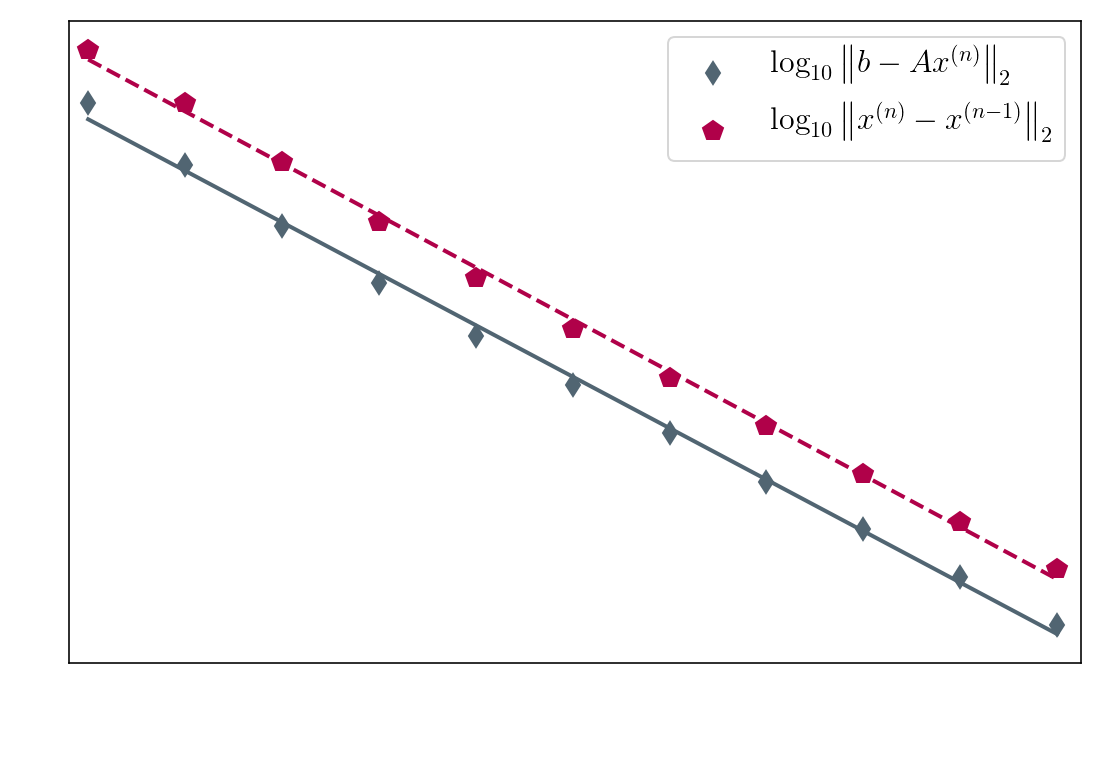

In [14]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
    
ndata= np.arange(0,cnt+1)[1:]
    
plt.plot(ndata, np.log10(res_data[1:]), 'd', color='xkcd:slate', markersize=8, label=r"$\log_{10}\left\|b-Ax^{(n)}\right\|_{2}$")
params = np.polyfit(ndata, np.log10(res_data[1:]), 1)
slope = params[0]
intercept = params[1]
plt.plot(ndata, slope*ndata+intercept, color='xkcd:slate', linewidth='2')

plt.plot(ndata, np.log10(speed_data), 'p', color='xkcd:raspberry',  markersize=10 ,label=r"$\log_{10}\left\|x^{(n)}-x^{(n-1)}\right\|_{2}$")
params = np.polyfit(ndata, np.log10(speed_data), 1)
slope = params[0]
intercept = params[1]
plt.plot(ndata, slope*ndata+intercept, color='xkcd:raspberry', linewidth='2', linestyle='--')

plt.xlim([0.8,cnt+0.25])
#plt.ylim([-5.6,2])

ax.legend(fontsize=16)

plt.xlabel(r"Iteration Number $n$", fontsize=26, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600
    
plt.show()

In this problem, we see essentially no difference between Gauss-Seidel and SOR with weight parameter $\omega=1.05$. 

In [15]:
# TODO: sort out algorithms better so pedagogical outputs are separate/there are not 5 
# outputs to handle and make the syntax extremely clumsy. 
# Currently setting a bad example for good coding practice!

In [16]:
# TODO: makes some pros and cons for Gaussian elimination vs Jacobi etc. in a nice 
# visual table

In [17]:
# TODO: make LU decomp + cg routines homemade

In [18]:
# TODO: Maybe try to come up with a test case that outperforms Gaussian elimination? 
# This is tough and will require some work with the sparse matrix package! 
# But really cool to have something that beats CG wrt error :) 

In [19]:
# TODO: can performance of relaxation-type methods be improved by manually getting rid of matmuls
# and replacing them with loops? 

In [20]:
#TODO: performance of relaxation methods as a function of the weight parameter?
#Example where relaxation is necessary to get convergence? 